# Data augmentation

This notebook explores data augmentation as a mean to increase the accuracy, particularly on the test set

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import metrics
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping,TensorBoard, ReduceLROnPlateau
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.layers import BatchNormalization, LeakyReLU 
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

import os
import numpy as np

# plotting
import matplotlib.pyplot as plt
import pathlib
from PIL import Image
import IPython.display as display

# to display confusion matrix
import seaborn as sn
import pandas as pd

### Aux functions



In [2]:
def get_label(file_path):
  # convert the path to a list of path components
  parts = tf.strings.split(file_path, os.path.sep)
  # The second to last is the class-directory
  return parts[-2] == classNames

def decode_img(img):
  # convert the compressed string to a 3D uint8 tensor
  img = tf.image.decode_png(img, channels=3)
  # Use `convert_image_dtype` to convert to floats in the [0,1] range.
  img = tf.image.convert_image_dtype(img, tf.float32)
  # resize the image to the desired size.
  return tf.image.resize(img, [32,32])

def get_bytes_and_label(file_path):
  label = get_label(file_path)
  # load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  return img, label

def show_data(s1,l1, s2,l2, labels, min):
    fig, ax = plt.subplots()
    X = np.arange(len(s1))

    models = labels
    plt.bar(X, s1, width = 0.4, color = 'b', label=l1)
    plt.bar(X + 0.4, s2, color = 'r', width = 0.4, label = l2)
    plt.xticks(X + 0.4 / 2, models)
    plt.ylim(top = 100, bottom = min)
    plt.legend(loc='upper left')
    plt.show()

def show_batch(image_batch, label_batch):
  columns = 8
  rows = BATCH_SIZE / columns + 1  
  plt.figure(figsize=(10, 2 * rows))
  for n in range(BATCH_SIZE):
      ax = plt.subplot(int(rows), columns, n+1)
      plt.imshow((image_batch[n]))
      plt.title(classNames[label_batch[n]==1][0])
      plt.axis('off')


def show_history(history):
    print(history.history.keys())

    # summarize history for accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='lower right')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper right')
    plt.show()    


def show_accuracies(labels, test, val): 

    fig, ax = plt.subplots()
    X = np.arange(len(test))

    plt.bar(X, test, width = 0.4, color = 'b', label='test')
    plt.bar(X + 0.4, val, color = 'r', width = 0.4, label = "val")
    plt.xticks(X + 0.4 / 2, labels)
    plt.ylim(top = 1.0, bottom = 0.97)
    plt.legend(loc='upper left')
    plt.show()    



def show_misclassified(predictions, ground_truth, images, num_rows = 5, num_cols=3):
    
    # Plot the first X test images with wrong predictions.
    num_images = num_rows*num_cols
    print(num_images)
    plt.figure(figsize=(2*2*num_cols, 2*num_rows))
    i = 0
    k = 0
    while k < len(images) and i < num_images:
        predicted_label = np.argmax(predictions[k])
        gt = np.where(ground_truth[k])[0][0]
        if predicted_label != gt:
            plt.subplot(num_rows, 2*num_cols, 2*i+1)
            plot_image(k, predictions[k], gt, images)
            plt.subplot(num_rows, 2*num_cols, 2*i+2)
            plot_value_array(k, predictions[k], ground_truth)
            i += 1
        k += 1
    plt.tight_layout()
    plt.show()


def plot_image(i, predictions_array, true_label, img):
    predictions_array, true_label, img = predictions_array, true_label, img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    
    plt.imshow(img, cmap=plt.cm.binary)
    
    predicted_label = np.argmax(predictions_array)
    if predicted_label == true_label:
      color = 'blue'
    else:
      color = 'red'
    
    plt.xlabel("{} {:2.0f}% ({})".format(classNames[predicted_label],
                                100*np.max(predictions_array),
                                classNames[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
    predictions_array, true_label = predictions_array, true_label[i]
    plt.grid(False)
    plt.xticks(range(8))
    plt.yticks([])
    thisplot = plt.bar(range(8), predictions_array, color="#777777")
    plt.ylim([0, 1])
    predicted_label = np.argmax(predictions_array)

    thisplot[predicted_label].set_color('red')
    thisplot[np.where(true_label)[0][0]].set_color('blue')   



def show_confusion_matrix(mat, classes):

    df_cm = pd.DataFrame(mat, range(classes), range(classes))
    plt.figure(figsize=(8,6))
    sn.set(font_scale=1.4) # for label size
    sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt='d') # font size

    plt.show()    

## Callbacks

Here we introduce a new callback: ReduceLROnPlateau: https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ReduceLROnPlateau

When the model is trapped in an area where no improvement can be achieved, it is sometimes benefic to reduce the learning rate.



In [25]:
def prepare_callbacks(file_path):

    checkpointer = ModelCheckpoint(filepath= file_path, 
                               monitor = 'val_accuracy',
                               verbose=1, 
                               save_weights_only=True,
                               save_best_only=True)


    earlyStopper = EarlyStopping(monitor='val_loss', min_delta = 0.0001, patience = 15, verbose = 1)

    reduceLR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.000000001, verbose = 1)

    return [checkpointer, earlyStopper, reduceLR]
    

## Batch size

Batch size is an important parameter when training a network. It can influence speed and generalization, not necessarily in the same direction. There is no golden rule for the batch size but 32 is a commom number to start with.

In here we go to 64 to achieve faster training epochs (rather than 32)

See: https://machinelearningmastery.com/how-to-control-the-speed-and-stability-of-training-neural-networks-with-gradient-descent-batch-size/



In [4]:
BATCH_SIZE = 64
IMAGE_SIZE = 32

## Settings

In [5]:
data_path = 'd:/vcpi/gtsrb'
log_and_model_path = 'd:/vcpi/dl05/'

### Prepare to load images

In [7]:
classNames = np.array(os.listdir(f'{data_path}/train'))
classNames

array(['00000', '00001', '00002', '00003', '00004', '00005', '00006',
       '00007'], dtype='<U5')

### Loading images takes place in here

In [8]:
BATCH_SIZE = 32
AUTOTUNE = tf.data.AUTOTUNE

dataset = tf.keras.preprocessing.image_dataset_from_directory(
    f'{data_path}/train',
    batch_size = None,
    label_mode = 'categorical',
    image_size=(32,32),
    shuffle=True)
 
normalize = tf.keras.layers.Rescaling(1.0/255) 
dataset = dataset.map(lambda x, y: (normalize(x), y))

Found 10200 files belonging to 8 classes.


### Information about image shape and size of training set

In [9]:
t = next(iter(dataset))
print(t[0].shape, t[1].shape)

# note: this only works if dataset is not repeating
dataset_length = dataset.cardinality().numpy()
print("Total images in dataset: ", dataset_length)  

(32, 32, 3) (8,)
Total images in dataset:  10200


# Version I - training with dataset only

### Preparing training, validation and test datasets

In [11]:
dataSolo = dataset
dataSolo = dataSolo.cache()
dataSolo = dataSolo.shuffle(buffer_size = dataset_length)
dataSolo = dataSolo.prefetch(buffer_size=10200)
dataSolo = dataSolo.batch(batch_size=BATCH_SIZE)

In [12]:
valset = tf.keras.preprocessing.image_dataset_from_directory(
    f'{data_path}/val',
    image_size = (32, 32),
    batch_size = None,
    label_mode = 'categorical',
    shuffle = True)
 
valset = valset.map(lambda x, y: (normalize(x), y))

valset = valset.cache()
valset = valset.batch(batch_size = 2580)
valset = valset.prefetch(buffer_size = AUTOTUNE)


Found 2580 files belonging to 8 classes.


In [13]:
testset = tf.keras.preprocessing.image_dataset_from_directory(
    f'{data_path}/test',
    image_size = (32, 32),
    batch_size = 128,
    label_mode = 'categorical',
    shuffle = True)

testset = testset.map(lambda x, y: (normalize(x), y))    

Found 4170 files belonging to 8 classes.


### Show a batch of training images

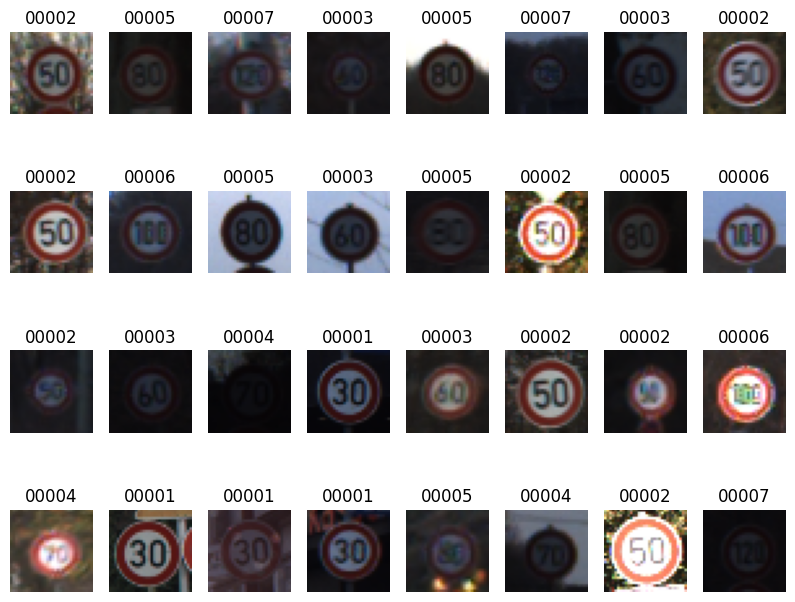

In [14]:
image_batch, label_batch = next(iter(dataSolo))        
show_batch(image_batch, label_batch.numpy())

### Build a CNN network

In [15]:
def model_VI(classCount, imgSize, channels):

    model = Sequential()
    
    model.add(Conv2D(128, (5, 5),
                     input_shape=(imgSize, imgSize, channels)))         
    model.add(LeakyReLU(alpha=0.01))  
    model.add(BatchNormalization())
    model.add(Dropout(0.5)) 

    model.add(Conv2D(196, (5, 5) )) 
    model.add(LeakyReLU(alpha=0.01))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.5)) 

    model.add(Conv2D(256, (5, 5) ) )   
    model.add(LeakyReLU(alpha=0.01))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.5)) 
    
    model.add(Flatten())
    model.add(Dense(384))
    model.add(LeakyReLU(alpha=0.01))             
    model.add(Dropout(0.5)) 
    
    model.add(Dense(classCount, activation='softmax'))

    
    opt = Adam(learning_rate=0.0001)
    model.compile(optimizer = opt, loss='categorical_crossentropy', metrics=[ 'accuracy'])
    return model


In [16]:
modelV1 = model_VI(8, 32, 3)

print(modelV1.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 128)       9728      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 28, 28, 128)       0         
                                                                 
 batch_normalization (BatchN  (None, 28, 28, 128)      512       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 28, 28, 128)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 196)       627396    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 24, 24, 196)       0         
                                                        

### Train the network 

In [19]:
file_pathV1 = f'{log_and_model_path}/V1/cp.ckpt'

In [26]:
callbacksV1 = prepare_callbacks(file_pathV1)

historyV1 = modelV1.fit(dataSolo,
          epochs = 50, 
          validation_data = valset, 
          callbacks = callbacksV1)          

Epoch 1/50
317/319 [============================>.] - ETA: 0s - loss: 0.0017 - accuracy: 0.9995
Epoch 1: val_accuracy improved from -inf to 0.98643, saving model to d:/vcpi/dl04//V1\cp.ckpt
319/319 [==============================] - 3s 10ms/step - loss: 0.0017 - accuracy: 0.9995 - val_loss: 0.0400 - val_accuracy: 0.9864 - lr: 3.1250e-06
Epoch 2/50
319/319 [==============================] - ETA: 0s - loss: 0.0016 - accuracy: 0.9994
Epoch 2: val_accuracy improved from 0.98643 to 0.98721, saving model to d:/vcpi/dl04//V1\cp.ckpt
319/319 [==============================] - 3s 10ms/step - loss: 0.0016 - accuracy: 0.9994 - val_loss: 0.0368 - val_accuracy: 0.9872 - lr: 3.1250e-06
Epoch 3/50
315/319 [============================>.] - ETA: 0s - loss: 0.0018 - accuracy: 0.9995
Epoch 3: val_accuracy did not improve from 0.98721
319/319 [==============================] - 3s 8ms/step - loss: 0.0018 - accuracy: 0.9995 - val_loss: 0.0380 - val_accuracy: 0.9868 - lr: 3.1250e-06
Epoch 4/50
312/319 [====

### Plot the training history

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


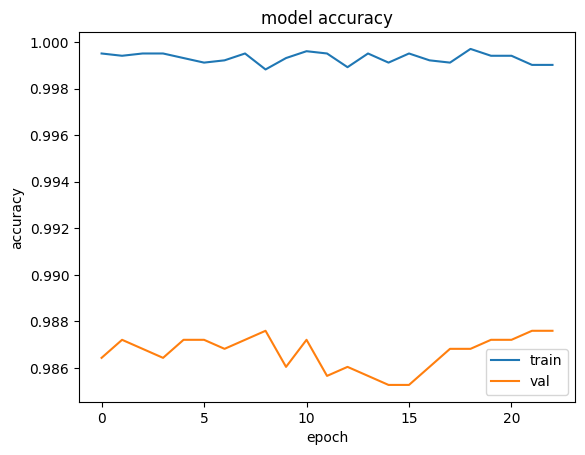

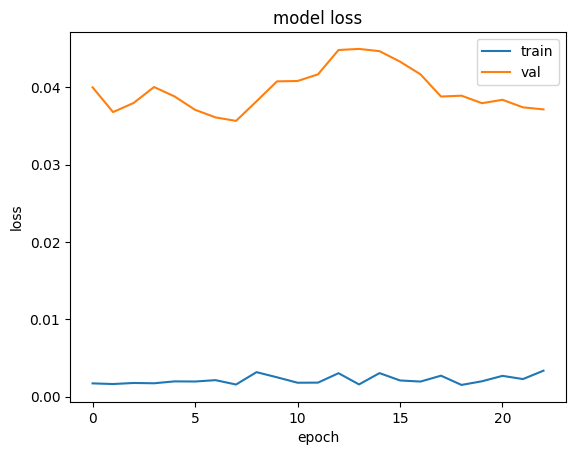

In [28]:
show_history(historyV1)

### Evaluate Model

In [27]:
modelV1.load_weights(file_pathV1)

evalV1 = modelV1.evaluate(testset, verbose=2)
valV1 = modelV1.evaluate(valset, verbose=2)

33/33 - 1s - loss: 0.1021 - accuracy: 0.9854 - 1s/epoch - 37ms/step
1/1 - 0s - loss: 0.0382 - accuracy: 0.9876 - 166ms/epoch - 166ms/step


# FIll code in here

# Version III - Massive data augmentation

### Data augmentation functions

In [37]:
import tensorflow_addons as tfa

def process_brightness(image, label):
    
    img = tf.clip_by_value(tfa.image.random_hsv_in_yiq(image, 0.0, 1.0, 1.0, 0.1, 3.0),0,1)
    return img, label

def process_saturation(image, label):
    
    img = tf.clip_by_value(tfa.image.random_hsv_in_yiq(image, 0.0, 1.0, 3.0, 1.0, 1.0),0,1)
    return img, label

def process_contrast(image, label):
    
    img = tf.clip_by_value(tf.image.random_contrast(image, lower=0.1, upper=3.0, seed=None), 0, 1)
    return img, label

def process_hue(image, label):
    
    img = tf.image.random_hue(image, max_delta=0.2, seed=None)
    return img, label

def process_rotate(image, label):
    
    img = tfa.image.rotate(image, tf.random.uniform(shape=(), minval=-0.175, maxval=0.175))
    return img, label

def process_shear(image, label):
    
    img = tfa.image.rotate(image, tf.random.uniform(shape=(), minval=-0.175, maxval=0.175))
    sx = tf.random.uniform(shape=(), minval=-0.1, maxval=0.1, dtype=tf.dtypes.float32)
    img = tfa.image.transform(img, [1, sx, -sx*32,   0,1,0,  0,0])
    return img, label

def process_translate(image, label):

    img = tfa.image.rotate(image, tf.random.uniform(shape=(), minval=-0.175, maxval=0.175))
    tx = tf.random.uniform(shape=(), minval=-3, maxval=3, dtype=tf.dtypes.float32)
    ty = tf.random.uniform(shape=(), minval=-3, maxval=3, dtype=tf.dtypes.float32)  
    img = tfa.image.translate(img, [tx,ty])
    return img, label

def process_crop(image, label):
    
    c = tf.random.uniform(shape=(), minval=24, maxval=32, dtype=tf.dtypes.float32)
    img = tf.image.random_crop(image, size=[c,c,3])
    img = tf.image.resize(img ,size= [32,32])
    return img, label

In [39]:
dataV3 = dataset
# color ops
dataV3 = dataV3.map(process_brightness)
dataV3 = dataV3.concatenate(dataset.map(process_contrast))
dataV3 = dataV3.concatenate(dataset.map(process_hue))
dataV3 = dataV3.concatenate(dataset.map(process_saturation))

#geometry ops
dataV3 = dataV3.concatenate(dataset.map(process_rotate))
dataV3 = dataV3.concatenate(dataset.map(process_shear))
dataV3 = dataV3.concatenate(dataset.map(process_translate))
dataV3 = dataV3.concatenate(dataset.map(process_crop))

dataV3 = dataV3.cache()
dataV3 = dataV3.shuffle(buffer_size = 81600)
dataV3 = dataV3.batch(batch_size = BATCH_SIZE)
dataV3 = dataV3.prefetch(buffer_size = AUTOTUNE)

In [40]:
modelV3 = model_VI(8, 32, 3)

file_pathV3 = f'{log_and_model_path}/DA_modelV3/cp.ckpt'


In [41]:
callbacksV3 = prepare_callbacks(file_pathV3)

historyV3 = modelV3.fit(dataV3,
          epochs = 50, 
          validation_data = valset, 
          callbacks = callbacksV3)          

Epoch 1/50
2543/2550 [============================>.] - ETA: 0s - loss: 1.2441 - accuracy: 0.5698
Epoch 1: val_accuracy improved from -inf to 0.95310, saving model to d:/vcpi/dl04//DA_modelV3\cp.ckpt
2550/2550 [==============================] - 39s 8ms/step - loss: 1.2420 - accuracy: 0.5706 - val_loss: 0.1392 - val_accuracy: 0.9531 - lr: 1.0000e-04
Epoch 2/50
2548/2550 [============================>.] - ETA: 0s - loss: 0.2871 - accuracy: 0.9035
Epoch 2: val_accuracy improved from 0.95310 to 0.98178, saving model to d:/vcpi/dl04//DA_modelV3\cp.ckpt
2550/2550 [==============================] - 20s 8ms/step - loss: 0.2870 - accuracy: 0.9036 - val_loss: 0.0588 - val_accuracy: 0.9818 - lr: 1.0000e-04
Epoch 3/50
2545/2550 [============================>.] - ETA: 0s - loss: 0.1611 - accuracy: 0.9468
Epoch 3: val_accuracy did not improve from 0.98178
2550/2550 [==============================] - 19s 7ms/step - loss: 0.1610 - accuracy: 0.9469 - val_loss: 0.0494 - val_accuracy: 0.9791 - lr: 1.0000

# Fill code in here - 2